In [1]:
import PbPMethods2 as pm2
from pylab import *
%matplotlib inline
import pandas as pd
import GetPbP
import matplotlib.patheffects as path_effects
import seaborn

In [2]:
seasons_to_update = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
#pm2.gen_gamebygame(season)

In [3]:
dfs = []
for season in range(2007, 2017):
    dfs.append(pd.read_csv(pm2.get_gamebygame_data_filename(season)))
dfs = pd.concat(dfs)
#dfs.head()

In [4]:
player = "Connor McDavid"
start_date = '2014-09-15' #use mid-Sept to be safe because some seasons have Euro premiere games
end_date = '2017-06-21' #Format: yyyy-mm-dd

teams = 'all' #or, e.g. {'WSH'}, or {'WSH', 'T.B'}
roll_len_gf = 40 #in games
roll_len_boxcars = 40 
roll_len_cf = 25

score_adjusted = True #Can also set to False. Method conceptually similar to @IneffectiveMath
include_playoffs = True #can also set to False
save_file = None #set to something to save figure
gapless = True #Will avoid long offseason flatlines (no games = no change in CF%)
ratestats = True #will divide by TOI if True
    
if teams == 'all':
    teams = GetPbP.TEAMS

In [5]:
df = dfs[dfs.Player == player]
df = df[df.Team.apply(lambda x: x in teams)]

df['Date2'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.sort_values('Date2', inplace=True)
df.set_index('Date2', inplace=True)
df = df.ix[start_date : end_date]

if gapless:
    df.reset_index(inplace=True)

if not include_playoffs:
    df = df[df.Game <= 21230]

In [6]:
cols_to_use = ['GF', 'GA']
if score_adjusted:
    cols_to_use += ['SACF', 'SACA']
else:
    cols_to_use += ['CF', 'CA']
    
cols_to_use += ['iG', 'iA1', 'iA2', 'GFON']
base = '{0:d}-game '.format(roll_len_boxcars)

df[base + 'TOI'] = pd.rolling_sum(df['TOION(60s)'], roll_len_boxcars, 0)
if ratestats:
    divisor = df[base + 'TOI']
else:
    divisor = 1    

df[base + 'G'] = pd.rolling_sum(df['iG'], roll_len_boxcars, 0)/divisor
df[base + 'A1'] = pd.rolling_sum(df['iA1'], roll_len_boxcars, 0)/divisor
df[base + 'A2'] = pd.rolling_sum(df['iA2'], roll_len_boxcars, 0)/divisor
df[base + 'GFON_box'] = pd.rolling_sum(df['GFON'], roll_len_boxcars, 0)/divisor
    
end_vars = [cols_to_use[0]+'%', cols_to_use[0]+' Off%'] 
end_vars += [cols_to_use[2]+'%', cols_to_use[2]+' Off%']

cols_to_use = [cols_to_use[0]+'ON', cols_to_use[1]+'ON', 
               cols_to_use[0]+'OFF', cols_to_use[1]+'OFF',
               cols_to_use[2]+'ON', cols_to_use[3]+'ON', 
               cols_to_use[2]+'OFF', cols_to_use[3]+'OFF']

cols_to_use2 = []
for i, col in enumerate(cols_to_use):
    if i < 4:
        cols_to_use2.append('{0:d}-game {1:s}'.format(roll_len_gf, col))
        df[cols_to_use2[-1]] = pd.rolling_mean(df[col], roll_len_gf, 0)
    elif i < 8:
        cols_to_use2.append('{0:d}-game {1:s}'.format(roll_len_cf, col))
        df[cols_to_use2[-1]] = pd.rolling_mean(df[col], roll_len_cf, 0)
df[end_vars[0]] = df[cols_to_use2[0]] / (df[cols_to_use2[0]] + df[cols_to_use2[1]])
df[end_vars[1]] = df[cols_to_use2[2]] / (df[cols_to_use2[2]] + df[cols_to_use2[3]])
df[end_vars[2]] = df[cols_to_use2[4]] / (df[cols_to_use2[4]] + df[cols_to_use2[5]])
df[end_vars[3]] = df[cols_to_use2[6]] / (df[cols_to_use2[6]] + df[cols_to_use2[7]])

In [7]:
def format_timestamp_as_mdyy(ts):
    st = str(ts).split(' ')[0]
    y, m, d = st.split('-')
    m = int(m)
    d = int(d)
    return '{0:d}/{1:d}\n{2:s}'.format(m, d, y)

In [8]:
indices_to_change_colors = [0]
teamnames = [df['Team'].iloc[0]]
team_annot_x = []
team_annot_y = [0.37]
colors = GetPbP.TEAM_COLOR_DCT[teamnames[0]]
c1 = colors[0]
c2 = colors[1]
color1 = [c1]
color2 = [c2]
next_year_indices = [0]
start_date2 = pd.Timestamp(df['Date2'].iloc[0])
end_date2 = pd.Timestamp(df['Date2'].iloc[-1])
next_year_dates = [format_timestamp_as_mdyy(start_date2)]
years_elapsed = 0
oneyr = pd.Timedelta('365 days')
for i in range(1, len(df)):
    if gapless:
        current_date = df['Date2'].iloc[i]
    else:
        current_date = df.index[i]
    if current_date - start_date2 >= (years_elapsed + 1) * oneyr:
        next_year_indices.append(i)
        next_year_dates.append(format_timestamp_as_mdyy(current_date))
        years_elapsed += 1
    
    if df['Team'].iloc[i] == df['Team'].iloc[i - 1]:
        pass
    else:
        indices_to_change_colors.append(i)
        teamnames.append(df['Team'].iloc[i])
        c1, c2 = GetPbP.TEAM_COLOR_DCT[teamnames[-1]]
        color1.append(c1)
        color2.append(c2)
        
        dt = df.index[indices_to_change_colors[-1] - 1]
        dt = dt - df.index[indices_to_change_colors[-2]]
        
        team_annot_x.append(df.index[indices_to_change_colors[-2]] + dt/2)
        nexty = team_annot_y[0] - team_annot_y[-1] + 0.4
        team_annot_y.append(nexty) #alternate between 0.37 and 0.40
        
indices_to_change_colors.append(len(df))
dt = df.index[-1]
dt = dt - df.index[indices_to_change_colors[-2]]
team_annot_x.append(df.index[indices_to_change_colors[-2]] + dt/2)

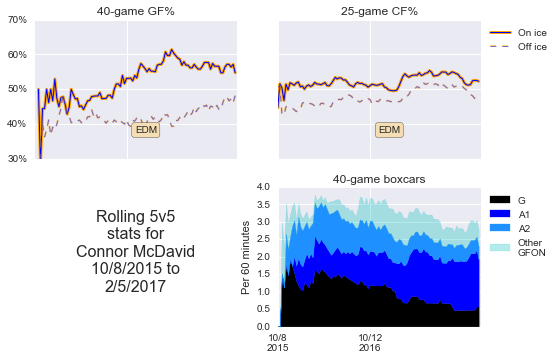

In [9]:
fig, axes = subplots(2, 2, sharex = True)
for i in range(len(indices_to_change_colors) - 1):
    starti = indices_to_change_colors[i]
    endi = indices_to_change_colors[i + 1]
    
    #plot dual-color line
    line = axes[0, 0].plot(df[end_vars[0]].iloc[starti : endi + 1], c=color2[i], 
                lw=1)
    line[0].set_path_effects([path_effects.Stroke(linewidth=3, foreground=color1[i]),
                           path_effects.Normal()])
    
    line = axes[0, 0].plot(df[end_vars[1]].iloc[starti : endi + 1], c=color2[i], 
                lw=1, ls='--', alpha=0.5)
    line[0].set_path_effects([path_effects.Stroke(linewidth=2, foreground=color1[i]),
                           path_effects.Normal()])
    
    axes[0, 0].annotate(teamnames[i], xy=(team_annot_x[i], team_annot_y[i]), va='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', edgecolor='black'), fontsize=10)
    
    line = axes[0, 1].plot(df[end_vars[2]].iloc[starti : endi + 1], c=color2[i], 
                lw=1, label='On ice')
    line[0].set_path_effects([path_effects.Stroke(linewidth=3, foreground=color1[i]),
                           path_effects.Normal()])
    
    line = axes[0, 1].plot(df[end_vars[3]].iloc[starti : endi + 1], c=color2[i], 
                lw=1, label='Off ice', ls='--', alpha=0.5)
    line[0].set_path_effects([path_effects.Stroke(linewidth=2, foreground=color1[i]),
                           path_effects.Normal()])
    
    axes[0, 1].annotate(teamnames[i], xy=(team_annot_x[i], team_annot_y[i]), va='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', edgecolor='black'), fontsize=10)
    
    if i == 0:
        axes[0, 1].legend(loc=2, bbox_to_anchor=(1, 1), fontsize=10)
    
axes[0, 0].set_ylim(0.3, 0.7)
ys = arange(0.3, 0.71, 0.1)
axes[0, 0].set_yticks(ys)
axes[0, 0].set_yticklabels(['{0:.0f}%'.format(y*100) for y in ys])

axes[0, 1].set_ylim(0.3, 0.7)
axes[0, 1].set_yticks(ys)
axes[0, 1].set_yticklabels(['' for y in ys])

if gapless:
    axes[0, 0].set_xlim(0, len(df))
    axes[0, 0].set_xticks(next_year_indices)
    axes[0, 0].set_xticklabels(next_year_dates, ha='left')
    axes[0, 1].set_xticklabels(next_year_dates, ha='left')
else:
    axes[0, 0].set_xlim(start_date2, end_date2)
    axes[0, 1].set_xlim(start_date2, end_date2)

axes[0, 0].set_title('{0:d}-game GF%'.format(roll_len_gf))
axes[0, 1].set_title('{0:d}-game CF%'.format(roll_len_cf))

axes[1, 1].fill_between(df.index, 0, df[base + 'G'], label='G', color='k')
axes[1, 1].fill_between(df.index, df[base + 'G'], df[base + 'G'] + df[base + 'A1'], label='A1', color='b')
axes[1, 1].fill_between(df.index, df[base + 'G'] + df[base + 'A1'], 
                        df[base + 'G'] + df[base + 'A1'] + df[base + 'A2'], 
             label='A2', color='dodgerblue')
axes[1, 1].fill_between(df.index, df[base + 'G'] + df[base + 'A1'] + df[base + 'A2'], 
             df[base + 'GFON_box'], label='Other\nGFON', color='c', alpha = 0.3)

axes[1, 1].set_title('{0:d}-game boxcars'.format(roll_len_boxcars))

if ratestats:
    axes[1, 1].set_ylabel('Per 60 minutes')

axes[1, 1].legend(loc=2, bbox_to_anchor=(1, 1), fontsize=10)
if ratestats:
    axes[1, 1].set_ylim(top=4)
else:
    axes[1, 1].set_ylim(top=round(0.75 * roll_len_boxcars))
    
axes[1, 0].axis('off')
titletext = 'Rolling 5v5\nstats for\n{0:s}'.format(player)
titletext += '\n{0:s} to\n{1:s}'.format(format_timestamp_as_mdyy(start_date2).replace('\n', '/'),
                                       format_timestamp_as_mdyy(end_date2).replace('\n', '/'))
axes[1, 0].set_title(titletext, va='center', y = 0.5, fontsize=16)

if save_file is not None:
    savefig(save_file)